This is to try and calculating remaining capacity in various large areas over run 29.

In [1]:
%matplotlib inline
import pandas as pd
import pandana as pdna
from matplotlib import pyplot as plt
from matplotlib import cm
from urbansim.utils import misc, networks

store = pd.HDFStore('./../runs/run29.h5')
pd.options.mode.chained_assignment = None

/home/pksohn/.conda/envs/semcog_urbansim/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
p = store['base/parcels']
b = store['base/buildings']

In [3]:
# Set up walk network

with pd.HDFStore('./../data/semcog_networks.h5') as net_store:
    nodes = net_store['nodes_mgf14_ext_walk']
    edges = net_store['edges_mgf14_ext_walk']
    net = pdna.Network(nodes["x"], nodes["y"], 
                       edges["from"], edges["to"],
                       edges[['feet']])

In [4]:
# Get average prices in base year

nodes_walk = pd.DataFrame(index=net.node_ids)
bldg = b.loc[(81 <= b.building_type_id)
            & (b.building_type_id <= 84)
            & (0 < b.sqft_price_res)
            & (b.sqft_price_res < 500)]
bldg = bldg.merge(p[['nodeid_walk']], left_on='parcel_id', right_index=True)

net.set(bldg['nodeid_walk'], variable=bldg['sqft_price_res'])
nodes_walk['sqft_price_res'] = net.aggregate(2000, type='average', decay='flat')
res_prices = misc.reindex(nodes_walk.sqft_price_res, p.nodeid_walk)
p['res_prices'] = res_prices

In [5]:
# Get price deciles

for lid in p.large_area_id.unique():
    parcels_lid = p.loc[p.large_area_id == lid][['res_prices']]
    parcels_lid['res_decile'] = pd.qcut(parcels_lid['res_prices'], 10, labels=False)
    p.loc[p.large_area_id == lid, 'res_decile'] = parcels_lid.res_decile

In [13]:
# At this point, DataFrame "p" has deciles for residential price in each large area
# As well as max_dua
# Let's get the two series here:

max_dua = store['base/zoning'].max_dua
res_deciles = p.res_decile

In [46]:
dfs = {}

for year in range(2016, 2046):
    parcels = store['{}/parcels'.format(year)]
    parcels['max_dua'] = max_dua
    parcels['max_units'] = parcels.max_dua * (parcels.parcel_sqft * 0.000022956841138659)
    parcels['res_decile'] = res_deciles
    
    buildings = store['{}/buildings'.format(year)]
    parcels['res_units'] = buildings.groupby('parcel_id').sum()['residential_units']
    parcels['unit_capacity'] = parcels.max_units - parcels.res_units
    
    result = parcels.groupby(['large_area_id', 'res_decile']).sum()
    result = result[['parcel_sqft', 'max_dua', 'max_units', 'res_units', 'unit_capacity']]
    
    dfs[year] = result

results = pd.concat(dfs.values(), keys=dfs.keys())

In [48]:
results.to_csv('run29_res_capacity.csv')

In [13]:
results = pd.read_csv('run29_res_capacity.csv', index_col=[0,1,2])

In [15]:
capacities = results.unstack(0)['unit_capacity']

In [16]:
lids = sorted(p.large_area_id.unique().tolist())

In [17]:
capacities.loc[lids[0]]

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,...,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045
res_decile,,,,,,,,,,,,,,,,,,,,,
0.0,22410.819535,22412.915610,22412.915610,22412.915610,22291.338934,22291.338934,22291.338934,22291.338934,22291.338934,24139.596510,...,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510,24139.596510
1.0,39663.518113,39663.518113,39663.518113,39663.518113,39543.518113,39543.518113,39543.518113,39543.518113,39543.518113,39543.518113,...,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113,39542.518113
2.0,18840.763491,18841.734496,18935.715568,18935.715568,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,...,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453,20212.540453
3.0,13839.787274,13839.497742,13839.497742,13839.497742,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,...,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728,13783.432728
4.0,13169.377021,13127.371488,13127.371488,13127.371488,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,...,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615,13152.729615
5.0,32691.510673,32691.101972,32690.101972,32690.101972,32628.249125,32628.249125,32628.249125,32628.249125,32628.249125,32628.249125,...,32628.249125,32628.249125,32628.249125,32628.249125,32628.249125,32628.249125,32628.249125,32625.412819,32625.412819,32625.412819
6.0,26808.744802,26725.271432,26711.336492,26692.833278,26687.427539,26687.427539,26687.427539,26687.427539,26687.427539,26728.028113,...,26723.608612,26723.608612,26724.604269,26725.326904,26725.326904,26725.326904,26725.326904,26725.326904,26725.326904,26725.326904
7.0,37961.519433,37973.322156,37905.991715,37905.991715,37991.528216,37991.528216,37991.528216,37991.528216,37991.528216,38005.510372,...,37571.780243,37570.565436,37570.764196,37568.963232,37567.622920,37567.445509,37568.144086,37489.424664,37488.127970,37488.127970
8.0,14992.652504,16852.215336,16661.395731,16661.395731,16171.531865,16171.531865,16171.531865,16171.531865,16171.531865,16142.293532,...,15683.487413,15663.487413,15632.575911,15597.575911,15585.795608,15537.450567,15537.468565,15506.468565,15479.354997,15474.961334


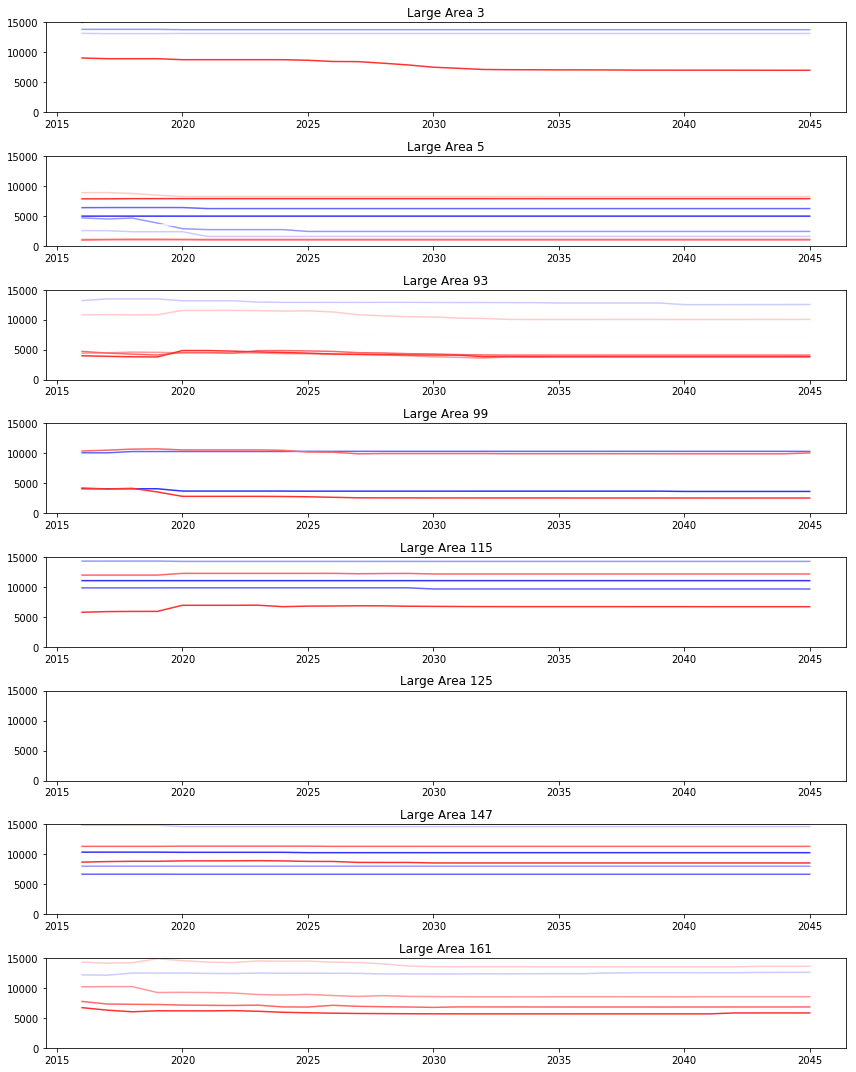

In [19]:
figure, axes_list = plt.subplots(len(p.large_area_id.unique()), 1, figsize=(12, 15))
for i, ax in enumerate(axes_list):
    lid_results = capacities.loc[lids[i]]
    ax.set_title('Large Area {}'.format(lids[i]))
    for d in range(10):
        row = lid_results.loc[d]
        ax.plot(row.index, row.values, color=cm.bwr(d/float(10)))
        ax.set_ylim(bottom=0, top=15000)
figure.tight_layout()

In [44]:
df= pd.read_csv('run29_res_capacity_2016.csv')

In [45]:
df

,large_area_id,res_decile,parcel_sqft,max_dua,max_units,res_units,unit_capacity
0,3,0.0,2.091512e+09,342408.228012,94148.616670,46803.0,22410.819535
1,3,1.0,8.078454e+08,233011.650349,102767.168968,50998.0,39663.518113
2,3,2.0,8.751223e+08,227984.570360,80137.566602,50987.0,18840.763491
3,3,3.0,7.037590e+08,244587.174451,70928.495253,46132.0,13839.787274
4,3,4.0,8.834404e+08,248207.088330,70181.179467,40993.0,13169.377021
5,3,5.0,1.307914e+09,236304.593752,96842.263101,47385.0,32691.510673
6,3,6.0,1.222072e+09,251992.296258,87839.207873,44515.0,26808.744802
7,3,7.0,1.333137e+09,230526.543661,103232.774706,49599.0,37961.519433
8,3,8.0,1.068311e+09,201417.661527,83161.681017,49390.0,14992.652504
9,3,9.0,1.108501e+09,155360.890552,61466.741985,43763.0,9057.629020
